In [22]:
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

seasons = ['2016-17', '2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23']

In [23]:
def access_season_player_data(season: str, previous_season: str, encoding: str) -> pd.DataFrame:
    players_df = pd.read_csv(f'../data/data/{season}/players_raw.csv')[[
        'first_name', 'second_name', 'id', 'team', 'total_points', 'minutes', 'selected_by_percent', 
        'now_cost', 'bps', 'goals_scored', 'assists'
    ]]
    gw1_previous_df = pd.read_csv(f'../data/data/{season}/gws/gw1.csv', encoding=encoding)[[
        'element', 'value'
    ]]
    gw1_previous_df.rename(columns={'value': 'previous_start_value'}, inplace=True)
    gw1_next_df = pd.read_csv(f'../data/data/{previous_season}/gws/gw1.csv', encoding=encoding)[[
        'name', 'value'
    ]]
    gw1_next_df.rename(columns={'value': 'target_value'}, inplace=True)
    gw1_next_df['name'] = gw1_next_df['name'].str.lower().str.replace('_', '').str.replace(' ', '') \
        .str.replace('0', '') \
        .str.replace('1', '') \
        .str.replace('2', '') \
        .str.replace('3', '') \
        .str.replace('4', '') \
        .str.replace('5', '') \
        .str.replace('6', '') \
        .str.replace('7', '') \
        .str.replace('8', '') \
        .str.replace('9', '') 
    teams_df = pd.read_csv(f'../data/webscraper_output/teams_webscraper.csv')
    teams_df = teams_df[teams_df['season'] == season]
    position_df = pd.read_csv('../data/data/cleaned_merged_seasons.csv', low_memory=False)[['position', 'element', 'season_x']]
    position_df['unique_id'] = position_df['element'].astype(str)  + '-' + position_df['season_x']
    position_df = position_df[position_df['season_x'] == season]
    combined = players_df.merge(gw1_previous_df, how='left', left_on='id', right_on='element').merge(teams_df, how='left', left_on='team', right_on='team_id') 
    combined['unique_id'] = combined['id'].astype(str)  + '-' + combined['season']
    combined['full_name'] = combined['first_name'].str.lower() + combined['second_name'].str.lower()
    final = combined.merge(position_df, how='left', on='unique_id').merge(gw1_next_df, how='left', left_on='full_name', right_on='name')
    final.rename(columns={'now_cost': 'previous_end_value'}, inplace=True)
    final['delta_value'] = final['previous_end_value'] - final['previous_start_value']
    final = final[[
        'unique_id', 'full_name', 'position', 'teams', 'minutes', 'goals_scored', 'assists', 
        'bps', 'selected_by_percent', 'previous_start_value', 'delta_value', 'target_value'
    ]]
    final = final.dropna().drop_duplicates()
    final[['minutes', 'goals_scored', 'assists', 'bps']] = final[['minutes', 'goals_scored', 'assists', 'bps']].astype(float)
    
    return final

In [24]:
player_df = pd.DataFrame(columns=['unique_id', 'full_name', 'position', 'teams', 'minutes',
       'goals_scored', 'assists', 'bps', 'selected_by_percent',
       'previous_start_value', 'delta_value', 'target_value'])
for i in range(len(seasons)-1):
    player_df = player_df.append(access_season_player_data(seasons[i+1], seasons[i], 'latin-1'), ignore_index=True)
    
player_df['position'] = player_df['position'].replace('GKP', 'GK')

# one hot encoding for categorical features
player_df_encoded = pd.get_dummies(player_df, columns=['position', 'teams'])
player_df_encoded


,unique_id,full_name,minutes,goals_scored,assists,bps,selected_by_percent,previous_start_value,delta_value,target_value,...,teams_nottinghamforest,teams_sheffieldunited,teams_southampton,teams_stokecity,teams_swanseacity,teams_tottenhamhotspur,teams_watford,teams_westbromwichalbion,teams_westhamunited,teams_wolverhamptonwanderers
0,7-2017-18,héctorbellerín,3050.0,2.0,4.0,656.0,10.3,60.0,-1.0,65.0,...,0,0,0,0,0,0,0,0,0,0
1,11-2017-18,robholding,819.0,0.0,1.0,196.0,0.7,50.0,-6.0,45.0,...,0,0,0,0,0,0,0,0,0,0
2,16-2017-18,mesutözil,2161.0,4.0,9.0,506.0,2.1,95.0,-2.0,95.0,...,0,0,0,0,0,0,0,0,0,0
3,18-2017-18,aaronramsey,1844.0,7.0,10.0,503.0,4.5,70.0,-2.0,80.0,...,0,0,0,0,0,0,0,0,0,0
4,21-2017-18,alexiwobi,1827.0,3.0,5.0,426.0,1.0,55.0,-4.0,60.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,484-2022-23,maxkilman,3307.0,0.0,1.0,622.0,3.1,45.0,-2.0,45.0,...,0,0,0,0,0,0,0,0,0,1
913,485-2022-23,lukecundle,0.0,0.0,0.0,0.0,0.2,45.0,-1.0,45.0,...,0,0,0,0,0,0,0,0,0,1
914,488-2022-23,fabiosilva,0.0,0.0,0.0,0.0,0.0,55.0,0.0,60.0,...,0,0,0,0,0,0,0,0,0,1
915,516-2022-23,nathancollins,1811.0,0.0,0.0,326.0,0.5,45.0,-3.0,45.0,...,0,0,0,0,0,0,0,0,0,1


In [25]:
player_df_encoded.describe()

,minutes,goals_scored,assists,bps,selected_by_percent,previous_start_value,delta_value,target_value,position_DEF,position_FWD,...,teams_nottinghamforest,teams_sheffieldunited,teams_southampton,teams_stokecity,teams_swanseacity,teams_tottenhamhotspur,teams_watford,teams_westbromwichalbion,teams_westhamunited,teams_wolverhamptonwanderers
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,...,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,1417.925845,2.001091,1.787350,266.407852,2.981352,53.942203,-1.648855,54.776445,0.354417,0.131952,...,0.008724,0.020720,0.073064,0.004362,0.003272,0.071974,0.008724,0.017448,0.069793,0.022901
std,1079.546702,3.830611,2.796897,220.831096,6.068500,13.009232,2.422360,13.082672,0.478597,0.338623,...,0.093045,0.142522,0.260384,0.065938,0.057135,0.258586,0.093045,0.131006,0.254937,0.149669
min,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,-9.000000,40.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,344.000000,0.000000,0.000000,59.000000,0.100000,45.000000,-3.000000,45.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1425.000000,0.000000,1.000000,236.000000,0.600000,50.000000,-2.000000,50.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2305.000000,2.000000,2.000000,430.000000,2.800000,55.000000,-1.000000,60.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3420.000000,30.000000,17.000000,1008.000000,44.500000,130.000000,14.000000,130.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
player_df_encoded.corr()

,minutes,goals_scored,assists,bps,selected_by_percent,previous_start_value,delta_value,target_value,position_DEF,position_FWD,...,teams_nottinghamforest,teams_sheffieldunited,teams_southampton,teams_stokecity,teams_swanseacity,teams_tottenhamhotspur,teams_watford,teams_westbromwichalbion,teams_westhamunited,teams_wolverhamptonwanderers
minutes,1.000000,0.411534,0.493866,0.946710,0.487413,0.296745,0.187078,0.226192,0.053881,-0.048604,...,-0.015731,0.029846,0.022642,0.093880,0.065067,0.005920,0.042763,0.033665,0.036600,-0.021881
goals_scored,0.411534,1.000000,0.634227,0.472080,0.676859,0.748479,0.293029,0.697206,-0.256267,0.363472,...,-0.021467,-0.050033,-0.028537,0.004303,-0.009993,0.073763,0.018351,-0.006564,-0.010139,-0.057169
assists,0.493866,0.634227,1.000000,0.551300,0.584918,0.610389,0.228082,0.555428,-0.165469,0.117264,...,0.002942,-0.057402,-0.026612,0.016875,0.004358,0.048356,-0.009644,-0.028596,0.013182,-0.069200
bps,0.946710,0.472080,0.551300,1.000000,0.620202,0.346189,0.327076,0.286141,0.090428,-0.057920,...,-0.025783,-0.020560,-0.009955,0.088872,0.062452,0.054774,0.016244,-0.005416,0.024625,-0.026542
selected_by_percent,0.487413,0.676859,0.584918,0.620202,1.000000,0.519815,0.596386,0.474617,-0.028620,0.111010,...,-0.004158,-0.052567,-0.066706,0.004296,0.017179,0.128447,-0.014212,-0.034607,-0.034088,-0.033064
previous_start_value,0.296745,0.748479,0.610389,0.346189,0.519815,1.000000,0.064111,0.916029,-0.335991,0.428231,...,-0.032953,-0.023494,-0.046450,-0.000978,-0.002683,0.094052,-0.019425,-0.017984,-0.023799,-0.071648
delta_value,0.187078,0.293029,0.228082,0.327076,0.596386,0.064111,1.000000,0.081883,0.093110,-0.076512,...,-0.023294,-0.109637,-0.047644,0.024574,0.039018,0.093808,0.020299,-0.067490,-0.041496,0.007907
target_value,0.226192,0.697206,0.555428,0.286141,0.474617,0.916029,0.081883,1.000000,-0.341276,0.415738,...,-0.011849,-0.067773,-0.060897,-0.005196,0.008282,0.083824,-0.002880,-0.035940,-0.028049,-0.078226
position_DEF,0.053881,-0.256267,-0.165469,0.090428,-0.028620,-0.335991,0.093110,-0.341276,1.000000,-0.288880,...,-0.020479,0.004259,-0.024055,0.020145,-0.002525,0.049474,0.004037,-0.029089,0.011787,0.038974
position_FWD,-0.048604,0.363472,0.117264,-0.057920,0.111010,0.428231,-0.076512,0.415738,-0.288880,1.000000,...,-0.001927,0.056391,0.026734,-0.025807,-0.022337,-0.046240,0.032722,0.046481,-0.018273,-0.016608


In [27]:
# drop features which have less than absolute 0.08 corr with target_value
columns = ['unique_id', 'full_name', 'minutes', 'goals_scored', 'assists', 'previous_start_value', 
           'delta_value', 'bps', 'selected_by_percent',
            'position_DEF', 'position_FWD', 'position_GK',
            'position_MID', 'teams_chelsea',
            'teams_liverpool', 'teams_manchestercity', 'teams_manchesterunited',
            'teams_newcastleunited', 'teams_tottenhamhotspur', 'target_value']

player_df_encoded = player_df_encoded[columns]

## (Training+Validation):Test --> 80:20

In [28]:
# ensure similar distribution for target using KS-test
for i in range(10000):
    training_data, test_data = train_test_split(player_df_encoded, test_size=0.20, random_state=i)
    ks_stat, p_value = scipy.stats.kstest(training_data["target_value"], test_data["target_value"])
    
    if p_value >= 0.99:
        print (i)
        print(p_value)
        training_data.to_csv("../data/model_dataset/training_set.csv")
        test_data.to_csv("../data/model_dataset/test_set.csv")
        break

7
0.9913700881255114


(array([ 7., 47., 53., 27., 13., 14.,  7.,  4.,  3.,  2.,  3.,  1.,  0.,
         1.,  2.]),
 array([ 40.        ,  44.66666667,  49.33333333,  54.        ,
         58.66666667,  63.33333333,  68.        ,  72.66666667,
         77.33333333,  82.        ,  86.66666667,  91.33333333,
         96.        , 100.66666667, 105.33333333, 110.        ]),
 <BarContainer object of 15 artists>)

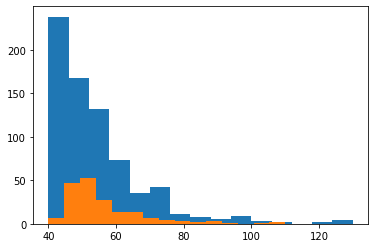

In [29]:
plt.hist(training_data["target_value"], bins=15)
plt.hist(test_data["target_value"], bins=15)